In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px 

from code import sequence, viral, embed, KNN

import warnings
warnings.filterwarnings('ignore')
# %matplotlib notebook

### Embed sequences using pre-trained model 

In [2]:
dataset, embeddings = viral.get_embedings()
edit_dists = viral.get_edit_dists(dataset)

embed_dists = embed.pairwise_embed_dist(embeddings)
data = embed.get_dataframe(dataset, edit_dists, embed_dists)
stats_summary = embed.get_stats(dataset, data)

['/cluster/work/grlab/home/ajoudaki/seqCNN/networks/seqCNN_in_channels4_num_layers8_channels1_kernel3_stride2_groups4_1623100075']


100%|██████████| 61/61 [00:00<00:00, 62.21it/s]


calculated for 15586 substrings, forming 242907694 pairs


### Sparsity of pairwise edit distance graph 

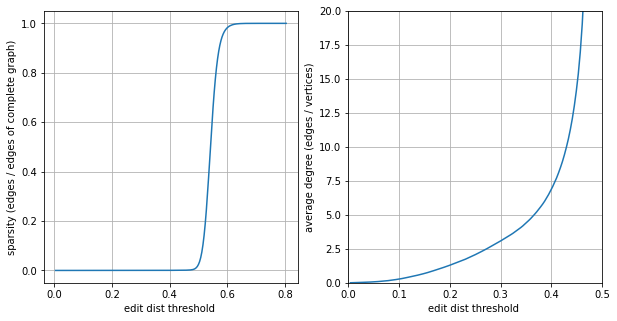

In [3]:
fig = embed.sparsity(edit_dists/dataset.L)
fig.show()

### Show sample embedding sequences 

In [ ]:
ed_neighbors = np.argsort(edit_dists, axis=1)
embed.sample_edit_vs_embed_dists(edit_dists/dataset.L, embed_dists, ed_neighbors)

In [ ]:
random_samples = embed.get_samples(dataset, data, num_samples=20)
viral.embed_vs_ed(dataset, random_samples, x='edit dist', y='embed dist')

### PR curve

In [ ]:
%%time 

d1 = .2
d2 = .35
recall = .99
max_len = 1500
ed_th = .15

NN, NN_dists = KNN.nn_index(embeddings, d1, d2, recall)
index = KNN.nn2index(NN,NN_dists)

_, recall = KNN.PR_curve(NN, embed_dists<d1)
_, recall2 = KNN.PR_curve(NN, edit_dists/dataset.L<ed_th)
print(f"recall embed dist = {recall:.5f}\n"
      f"recall edit dist = {recall2:.5f}\n"
      f"embed dist calls per sample {int(NN.shape[0]/len(dataset))}")

len(dataset), embeddings.shape, NN.shape, NN.shape[0]/len(dataset)

# Cosine nearest neighbor search 

Given matrix $X \in R^{D\times N}$ with unit-norm columns $\|x_1\|, \dots, \|x_N\|=1$, for $0<d_1<d_2<1$ we assume at most $c N$ pairs are closer than $d_2$: 
$$|\{(i,j): \|x_i-x_j\|^2\le d_2\}|\le c N$$ 
for some $c=O(1)$. We want to retrieve $1-\delta$ of pairs closer than $d_1$, with the complexity growing sub-quadratically in $N$. 
- Step 1: Given integers $m,M$ (TBD), draw $M$ Gaussian matrices $G_1,\dots, G_M \sim \mathcal{N}(0,I_{m\times D})$
- Step 2: project $X$ onto $\pm 1$ matrices $Y_1,\dots, Y_M$ and take the sign $Y_j = sign( G_j X )$
    - complexity: $N D m M$ overall 
- Step 3: retrieve all pairs $(i,j)$ that collide $y^k_i=y^k_j$s for at least one of the sign matrices $k=1,\dots, M$. 
    - complexity of finding indices in that collide: $C M + C' D$ where $C=C_1+\dots, C_M$ is the number of colliding pairs in each ietration and $C'$ is the number of unique colliding pairs for which we compute the exact distance in $R^D$. 

Note that for unit vectors $u,v\in R^D$ Gaussian vecotor $w\sim \mathcal{N}(0,I_D)$, the probability that sign of $w^\top u$ is different from $w^\top v$ is their angle divided by $\pi$: $P(sign(w^\top u) \neq sign(w^\top v)) = \frac{\theta}{\pi}$, where $\theta$ is the angle between the vectors. Therefore, we can derive $\theta$ from the distance $f(d):=\frac{\theta}{\pi}=\frac{1}{\pi}\cos^{-1}(\frac{1-d}{2})$. Therefore we can convert the distance thresholds $d_1,d_2$ to probability thresholds $0<\theta_1<\theta_2<1$ using this transformation $\theta_1=f(d_1),\theta_2=f(d_2)$.  

The number of colliding pairs has two components: 1) pairs closer than $d_2$ are at most $c N$, amount to $c N (M+D)$ cost. 2) In expectation we have at most $\binom{N}{2}(1-\theta_2)^m$ pairs with distance $d_2$ or more in each iteration, totalling $M D \binom{N}{2}(1-\theta_2)^m$ cost, since the colliding pairs are in worst case distinct in each iteration. Since the second term is clearly the dominant one, we equate the complexity of projection and neighbor finding to derive the optimal parameters. 

$N D m M = M D \binom{N}{2} (1-\theta_2)^m$ which can be simplified to 
$$\frac{(1-\theta_2)^{m}}{m} \le \frac{2}{N}$$
On the other hand, in order to ensure $1-\delta$ recall we must have 
$$M\ge \frac{\log(1/\delta)}{ \log \frac{1}{(1-(1-\theta_1)^m )} }$$

In [9]:
%%time 

d1 = .3
d2 = .4
recall = .90
max_len = 1500

ed_th = .3
num_samples = 100
th = .3

dataset, embeddings = viral.get_embedings(max_len) # max_len=max_len, num_layers=10, groups=2, kernel=5
sample_dists, samples = embed.sample_edit_dist(dataset, num_samples)

NN, NN_dists = KNN.nn_index(embeddings, d1, d2, recall)
print("searching for sample data")
index = KNN.search(NN, NN_dists, samples)

target = sample_dists/dataset.L < ed_th
recall, dist_calls = KNN.sample_PR(samples, target, index, th=th)
print("computing summary")
df = viral.target_summary(embeddings, samples, dataset, target, index, print_info=False, max_sh=1)

print(f"recall edit dist < {ed_th} = {recall:.5f}\n"
      f"embed dist calls per sample {int(NN.shape[0]/len(dataset))}\n"
      f"edit dist calls per sample {int(dist_calls/num_samples)}\n"
      f"dataset size {len(dataset)}")


  0%|          | 6/1896 [00:00<00:32, 58.65it/s]

['/cluster/work/grlab/home/ajoudaki/seqCNN/networks/seqCNN_in_channels4_num_layers8_channels1_kernel3_stride2_groups4_1623100075']


100%|██████████| 1896/1896 [00:31<00:00, 60.21it/s]


CPU times: user 32 s, sys: 4.81 s, total: 36.8 s
Wall time: 36.7 s


In [ ]:
# df = viral.target_summary(embeddings, samples, dataset, target, index, print_info=False, max_sh=1)
px.scatter(df, df.ed/dataset.L, y='embed_dist', hover_data=["ed_sh","sample"], color="indexed")

# plt.plot(np.sort(sample_dists[sample_dists>0])/dataset.L,np.arange(np.sum(sample_dists>0)))
# plt.grid('on')

In [ ]:
viral.summary_viewer(df=df, dataset=dataset)